# ANOMALY DETECTION

### Anomaly detection vs novelty detection

La principale differenza tra novelty detection e anomaly detection è che per anomaly detection si intende l'individuazione degli outlier tra i dati di training, mentre per novelty detection si intende l'individuazione degli outlier tra i dati del test set.

## **Boxplot**
Un modo ottimale per individuare dei dati anomali sono i boxplot. I boxplot infatti essendo costruiti con i dati mediani, il primo e il terzo percentile, permette di individuare i valori dove si concentra il 50% dei dati, individuando tramite dei punti i dati anomali che escono oltre gli outlier limits. 

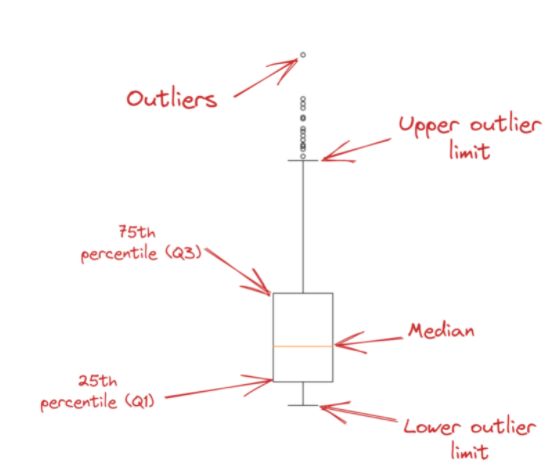

dove:
lower limit = Q1 - 1.5 * IQR

upper limit = Q3 + 1.5 * IQR


In [ ]:
import matplotlib.pyplot as plt
plt.boxplot(data)
plt.show()

# è possibile isolare i dati outlier individuati dal boxplot tramite il seguente codice

q1 = data.quantile(0.25)
q3 = data.quantile(0.75)

IQR = q3 - q1

factor = 2.5

#calcolo l'upper e lower limit
lower_limit = q1 - (IQR*factor)
upper_limit = q3 - (IQR*factor)

#creo due variabili booleane
is_lower = data < lower_limit
is_higher = data > upper_limit

#filtro i dati
outlier = data[is_lower | is_higher] # ho trovato i dati di outlier

## **Z-score**

Un altro strumento utilizzato per fare anomaly detection è lo Z-Score, questo essendo calcolato come rapporto tra la differenza tra il singolo valore e la medica con la deviazione 
standard, permette di identificare la distribuzione standardizzata della serie. Sfruttando l'Empirical rule si puù identificare la distribuzione e la probavilità associata alla serie

**empirical rule**

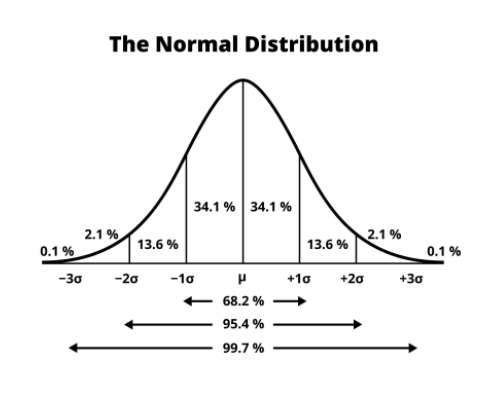

In dati normalmente distribuiti si è soliti impostare 3 come soglia che permette di individuare i dati anomali. Il limite principale è che il metodo dello Z-Score può essere utilizzato solo quando i dati sono normalmente distribuiti, inoltre la media e la std sono ovviamente influenzati dagli outlier.

In [ ]:
from scipy.stats import zscore
import numpy as np

Z_score = zscore(data)

is_over_3 = np.abs(data) > 3 # creo una variabile booleana per filtrare i dati

outliers = data[is_over_3]

In [ ]:
# Questo stesso calcolo può essere fatto con PyOD col modello MAD
#The modified z-score to use as a threshold. Observations with a modified z-score (based on the median absolute deviation) greater than this value will be classified as outliers.

from pyod.models.MAD import MAD

mad = MAD(threshold = 3.5) #in realtà viene settata a 3.5 di default

# Reshape prices to make it 2D
data_reshaped = data.values.reshape(-1, 1)

# Fit and predict outlier labels on prices_reshaped
labels = mad.fit_predict(data_reshaped)

# Filter for outliers
outliers = data[labels == 1]


# **Isolation Forest**

Gli isolation forests sono algoritmi molto utili per identificare **Multivariate anomalies** ovvero quei dati composti da più features che se prese singolarmente non caratterizzano un outlier, ma tutte insime definiscono un dato anomalo. Per una maggiore spiegazione su come funziona l'algoritmo di un random forest si rimanda al file RandomForest.ipynb.
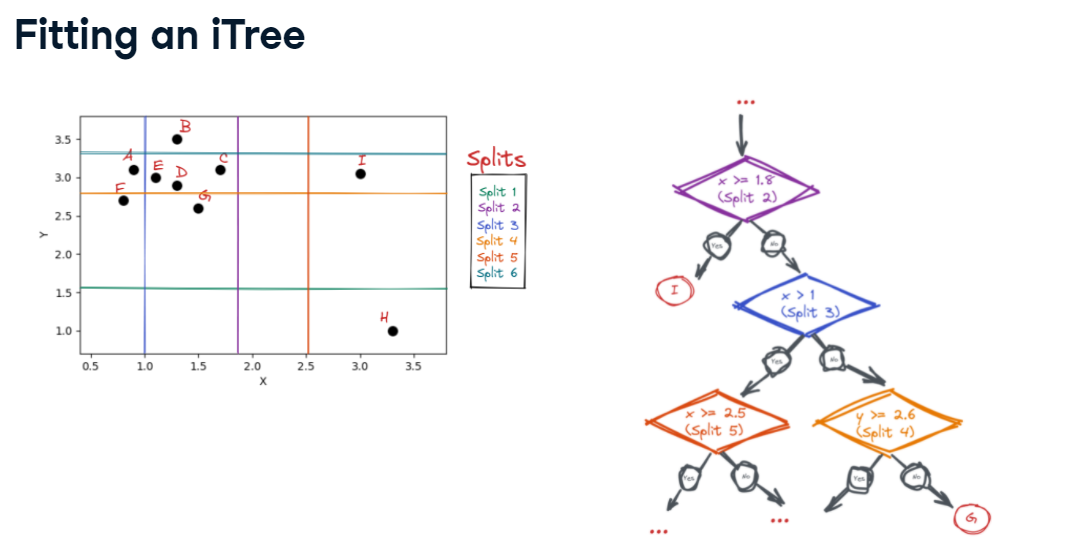

L'isolation forest permette di identificare dati anomali eseguendo degli splits all'interno del dataset. Ad ogni split corrisponde un nodo dell'albero, dove si verifica a quale delle "due metà" del dataset splittato appartiene il dato. Facendo questa iterazione è quindi possibile costrure un albero dove ogni singolo dato è stato correttamente categorizzato in una foglia. 

In [ ]:
from pyod.models.iforest import IForest

iforest = IForest()
labels = iforest.fit_predict(data) #l'algoritmo iforest segna gli outlier come 1 e gli inlier come 0

outliers = data [labels == 1]

print(len(outliers))

All'interno del Random Forest è possibile andare a individuare degli hyperparameters: contamination, n_estimators, max_samples, max_features.

- **contamination**: si intende un parametro che permette di identificare i valori anomali dai valori normali (threshold). Ad esempio utilizzando una soglio al 10% vuol dire che stiamo selezionando come valori anomali, quei valori per cui il modello ha generato uno score più elevato del restante 90% dei dati. 

- **n_estimators**: questo parametro ci permette di identificare il numero corretto di isolation tree da utilizzareper il nostro modello di isolation Forest (che è composto da n isolation tree (di default sono 1000 che di solito sono sufficienti per dataset non troppo grandi)

- **max_samples, max_features**: sono parametri che permettono di selezionare il numero di features e di dati da utilizzare per il modello. Ad esempio settando max_samples = 0,6, max_features = 0.9 mi permette di utilizzare il 90% delle features e il 60% dei dati. Chiaramente sono valori che oscillano tra 0 e 1. Questi valori permettono di ridurre il rischio di overfitting.

Un problema importante con cui ci si deve confrontare è che il problema dell'anomaly detection è un problema di UnSupervised Learning, quindi a differenza dei modelli di Supervised Learning non è possibile utilizzare RMSE o il log loss per vedere quale sia il modello migliore. L'unico modo per verificare quali siano i migliori HyperParameters è combinare modelli di outlier detection con modelli di Supervised Learning

# **HyperParameter tuning**

Definizione di una funzione che sulla base del modello pyod inserito restituisce i dati non anomali

In [ ]:
def evaluate_outlier_classifier(model, data)
""" Questa funzione prende in input una determinata tipologia di modello pyod e il dataset
e restituisce gli inliers, ovvero i dati non considerati anomali"""
    # Get labels
    labels = model.fit_predict(data)
    
    #Inliers
    return data[labels == 0] #ricordiamo che i modelli pyod segnano con 0 gli inlier e con 1 gli outlier


In [ ]:
# Versione più evoluta dell' evaluate_outlier_classifier
def evaluate_outlier_classifier(model, data, threshold)
""" Questa funzione prende in input una determinata tipologia di modello pyod e il dataset
e restituisce gli inliers, ovvero i dati non considerati anomali"""
   
    model.fit(data)
    
    probs = model.predict_proba(data)
    inliers = data[probs[:,1] <= threshold]
    fe
    return inliers


Per poter fare il fine tuning degli hyperparameters del modello è necessario affiancare al un modello di anomaly detection anche un modello di modellizzaizone dei dati NON anomali.
Il modello di anomaly detection, sulla base degli hyperparameters settati, individuerà outlier e inlier. Ma essendo un modello Unsupervised, non è possibile andare a calcolare indicatori di errore sul modello. Per questo poi costruiamo un modello di regressione lineare sugli inlier, perchè essendo modelli supervised, possiamo calcolarne gli indicatori di errore (come il RMSE). Di conseguenza il miglior modello di Outlier detection sarà quello che permetterà di individuare gli inliers dove, se io ci costruisco un modello per definirne l'andamento, permettono di ottenere il più basso indice d'errore.

In [ ]:
from sklearn.linear_regression import LinearRgression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def evaluate_regressor(inliers)
""" questa funzione prende in input i dati inliers ottenuti come output della funzione evaluate_outlier_classifier 
e li utilizza per modellizzare un modello di regressione lineare"""

    X = insliers.drop("sales", axis=1)
    y = inliers[['sales']]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    
    lr = LinearRgression()
    lr.fit(X_train,y_train)
    
    preds = lr.predict(X_val)
    rmse = mean_squared_error(val_y, preds, sqaured = False)
    
    return round(rmse, 3)
    

Questo è il caso in cui provare a fare il tuning di **un solo** hyperparameter

In [ ]:
contaminations = [0.05, 0.1, 0.2, 0.3]

scores = dict() #creo un dictionary dove andare a storare tutti i valori degli indicatori d'errore per ogni hyperparameter

for c in contaminations:
    iforest = IForest(contamination = c, randm_state = 10)
    inliers = evaluate_outlier_classifier(ifroest, data)
    scores[c] = evaluate_regressor(inliers)

Se invece volessi fare il tuning di **più hyperparameter**

In [ ]:
contaminations = [0.05, 0.1, 0.2, 0.3]
max_sample = [0.05, 0.1, 0.2, 0.3]
estimators = [0.05, 0.1, 0.2, 0.3]

scores = dict()

#invece di fare il ciclo for, in questo caso è necessario considerare tutte le possibili combinazioni ottenibili dai parametri settati.
# list(product(contaminations, max_sample, estimators)) --> questo codice ad esempio permette di ottenere il prodotto cartesiano tra i valori settati per gli hyperparameters
# l'output di questo sarà infatti tutte le coppie possibili dei valori degli hyperparameters settati

for c,m,e in product(contaminations, max_sample, estimators):
    iforest = IForest(contamination = c, max_sample = m, estimators = e, randm_state = 10)
    inliers = evaluate_outlier_classifier(ifroest, data)
    scores[(c, m, e)] = evaluate_regressor(inliers)


# **Probability Scores**

In [ ]:
all_probs = iforest.predict_probna(dataset)
print(all_probs)

# in questo caso, l'output del metodo predict_proba è un array di due dimensioni, dove la prima colonna è la probabilità che il dato sia un inlier, 
# mentre la seconda colonna è la probabilità che il dato sia un outlier. 

Per fare un check manuale sulla precisione del modello di anomaly detection, è possibile prendere un determinato numero di valori classificati come outlier e verificarne la probabilità di essere un outlier associata da predict_proba.

In [ ]:
outliers = data[iforest.labels_ == 1]
outliers_prob = iforest.predict_proba(outliers)

Il predict_proba può diventare anch'esso un metodo per fare outlier detection. Anzichè utilizzarlo come metodo per confrontare e verificare l'accuratezza del nostro modello, può essere utilizzato per isolare i dati che hanno una probabilità di essere outlier maggiore di una treshold (65%).

In [ ]:
prob = iforest.predict_proba(data)
outliers_prob = prob[:,1]
outliers = data[outliers_prob >= 0.65]

print(len(outliers))

# **Key Nearest Neighbours**

L'algoritmo k-nearest neighbors, noto anche come KNN o k-NN, è un classificatore di apprendimento supervisionato non parametrico, che utilizza la prossimità per effettuare classificazioni o previsioni sul raggruppamento di un singolo punto dati. Sebbene possa essere utilizzato per problemi di regressione o classificazione, viene generalmente utilizzato come algoritmo di classificazione, basandosi sul presupposto che punti simili possono essere trovati l'uno vicino all'altro. Spesso viene definito come algoritmo all'apprendimento pigro, questo perchè tutto il grosso del calcolo computazionale viene eseguito durante la fase di classificazione o di previsione. 
Per misurare la distanza tra due punti possono essere usate diverse formule, tra cui:
1. DISTANZA EUCLIDEA $\sqrt{\sum \limits _{j=1} ^{n} (y_i - x_i)}$ *è la più comune ma da dei problemi con dati con dimensioni superiori alle 2/3*
2. DISTANZA DI MANHATTAN $\sum \limits _{j=1} ^{n} |x_i - y_i|$ *lavora bene con dati ad elevata dimensioni e soprattuto con dati con features categoriche*
3. DISTANZA DI MINKOVSKI $\sum \limits _{j=1} ^{n} |x_i - y_i|^(1/p)$ 
4. DISTANZA DI HAMMING $\sum \limits _{j=1} ^{K} |x_i - y_i|$

L'algoritmo cercherà di minimizzare queste distanze al fine di clusterizzare al miglior modo possibile il dato.
Il valore di k nell'algoritmo knn definisce quanti vicini verranno considerati e quindi controllati per determinare la classificazione per un punto di query specifico. Valori inferiori di k possono portare a una elevata volatilità ma a una bassa distorsione, mentre valori elevati di k possono portare a una bassa volatilità ma a una elevata distorsione. In generale è consigliabile utilizzare un numero dispari di k in modo da evitare pareggi.
NKK è un modello non parametrico, il che vuol dire che non fa assunzioni statistiche sulla distribuzione statistica delle features dei dati

L'algoritmo KNN permette inoltre di fare unsupervised classification per anomaly detection. Questo lo ha reso tra gli algoritmi più semplici da applicare, in oltre a differenza dell'isolation forest il KNN ha bisogno di molti meno paramtetri:
1. Isolation Forest:
- Tree depth
- Sub-sample size
- Altre componenti

2. KNN:
- n_neighbors (k)

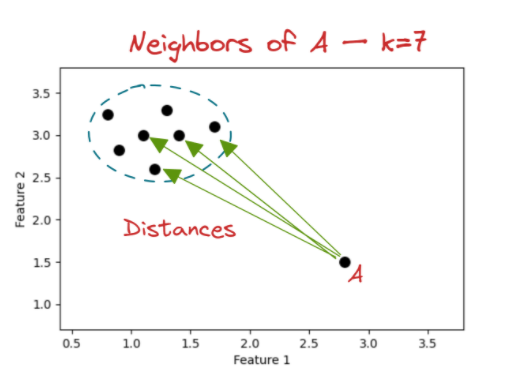

In [ ]:
from pyod.models.knn import KNN

knn = KNN(contamination = 0.01, n_jobs = -1) #non è stato messo l'hyperparameter n_neighbors. Solitamente per un valore di contamination <= 0,1 viene settato n_neighbors  
                                             #a 20, altrimenti, per valori di contaminazione maggiori di 0.1 è necessario aumentare il valore di n_neighbors
knn.fit(data)

probs = knn.predict_proba(data)

is_outlier = probs[:,1] > 0.55
outliers = data[is_outlier]

print(len(outliers))


#### StandardScaler

Un problema del KNN è che è molto sensibile alle unità di misura, per cui quando si utilizzano dei modelli KNN è importante standardizzare le features. Esistono diversi modi per effettuare una standardizzazione, uno di questi è la **standardizzazione semplice** in cui ad ogni instance è sottratta la media ed è poi divisa per la deviazione standard.

In [ ]:
from sklearn.preprocessing import StandardScaler #QuantileTransformer

ss = StandardScaler() #QuantileTransformer

#estrazione delle features e dei target
X = data.drop("nome della colonna da standardizzare", axis=1)
y = data[['nome della colonna da standardizzare']]

#Fit
ss.fit(X)

X_trasformed = ss.fit_transform(X)


### **Hyperparameter tuning per algoritmi KNN**

Spesso ci si può trovare a dover fare il fine tuning dell'**hyperparameter n_neighbors** per modelli KNN di outlier detection.
Il criterio è lo stesso dei Fine Tuning visti in precedenza:

In [ ]:
n_neighbors = [5, 10, 15, 20]
scores = dict()

for c in n_neighbors:
    knn = KNN(n_neighbors = k)
    inliers = evaluate_outlier_classifier(knn, data, .55) #in questa sezione utilizzo la funzione evaluate_outlier_classifier con definizione della soglia, se avessi usato l'altra funzione, non avrei inserito il valore della soglia
    scores[k] = evaluate_regressor(inliers)


In [ ]:
ps = [1, 2, 3, 4]
methods = ["largest", "mean", "median"]
scores = dict()

for p, method in product(ps, methods): #sempre il prodotto cartesiano per avere tutte le combinazioni tra i seguenti parametri
    knn = KNN(n_neighbors = 10, method = method, p=p, n_jobs=-1)
    inliers = evaluate_outlier_classifier(knn, data, .55) #in questa sezione utilizzo la funzione evaluate_outlier_classifier con definizione della soglia, se avessi usato l'altra funzione, non avrei inserito il valore della soglia
    scores[(p, method)] = evaluate_regressor(inliers)


# **Local Outlier Factor LOF**

_______________________________________

In [ ]:
from pyod.model.lof import LOF

#fit
lof = LOF(n_neighbors = 20, metric = "manhattan")
lof.fit(data_transformed)

probs = lof.predict_proba(data_transformed)

is_outlier = probs[:,1] > 0.55
outliers = data_transformed[is_outlier]

len(outliers)

Così come fatto per l'algoritmo KNN, anche per il LOF è possibile fare il tuning del parametro n_neighbors